In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import seaborn as sns

In [2]:
#ee.Authenticate()
#geemap.update_package()

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

x = pd.DataFrame(
    {
        'Site':['LTE-MP-LPP','LTE-MP-LPA'], 'Latitude':[42.730953216553,42.731742858887],
        'Longitude':[-70.842918395996,-70.842468261719]
    }
)

dfy = pd.concat([x]*22,ignore_index=True)

y = pd.Series(range(1999,2021))

dfy['Year'] = pd.concat([y]*2,ignore_index=True)

ma_pts = ee.FeatureCollection(
    [
        ee.Feature(ee.Geometry.Point([-70.842918395996, 42.730953216553]), {'Site': 'LTE-MP-LPP'}),
        ee.Feature(ee.Geometry.Point([-70.842468261719, 42.731742858887]), {'Site': 'LTE-MP-LPA'}) 
    ]
)

##Adding every plot coordinate
s_patens = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Massachusetts/LTE-MP-LPP-biomass.csv')
s_alterniflora = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Massachusetts/LTE-MP-LPA-biomass.csv')

s_patens['Latitude'] = 42.730953216553
s_patens['Longitude'] = -70.842918395996

s_alterniflora['Latitude'] = 42.731742858887
s_alterniflora['Longitude'] = -70.842468261719

s_patens.rename(columns={'LIVE biomass':'liveMass'}, inplace=True)
s_alterniflora.rename(columns={'MEAN BIOMASS':'liveMass'}, inplace=True)

df = pd.concat([s_patens, s_alterniflora])

df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

# df = df[df['TRT'] == 'C'] ##Remove fertilized plots? Since they won't represent the pixel well. But they might?

dfx =  df.groupby(['SITE', 'Date'], as_index = False).aggregate(
    {
        'Longitude':[np.mean], 'Latitude':[np.mean], 'liveMass':[np.mean, np.size], 
        'MONTH':'first', 'YEAR':'first'
    }
) 

dfx.columns = [
    'Site','Date','Longitude','Latitude','liveMass', 'Sample size','Month', 'Year'
]


dfx.loc[dfx['Site'] == 'LTE-MP-LPP', 'Latitude'] = 42.730953216553
dfx.loc[dfx['Site'] == 'LTE-MP-LPP', 'Longitude'] = -70.842918395996

dfx.loc[dfx['Site'] == 'LTE-MP-LPA', 'Latitude'] = 42.731742858887
dfx.loc[dfx['Site'] == 'LTE-MP-LPA', 'Longitude'] = -70.842468261719


display(dfx) ##Grouped by site and date; average biomass

# dfxend = dfx[dfx['Month'] == 9]
# dfxend

##NOTE: Structure of data extraction will have to be diff from VA/GA - lag variables/month sampled will change FOR EACH ROW
##in the current dataset (since samlping occurs in different months for each row). Not exactly sure how to do this yet.

fc_all = geemap.pandas_to_ee(dfx, latitude = 'Latitude', longitude = 'Longitude')

,Site,Date,Longitude,Latitude,liveMass,Sample size,Month,Year
0,LTE-MP-LPA,1999-06-30,-70.842468,42.731743,578.075000,4,6,1999
1,LTE-MP-LPA,1999-07-24,-70.842468,42.731743,486.750000,4,7,1999
2,LTE-MP-LPA,1999-08-27,-70.842468,42.731743,389.725000,4,8,1999
3,LTE-MP-LPA,1999-09-22,-70.842468,42.731743,441.625000,4,9,1999
4,LTE-MP-LPA,1999-10-26,-70.842468,42.731743,211.300000,4,10,1999
...,...,...,...,...,...,...,...,...
210,LTE-MP-LPP,2020-08-02,-70.842918,42.730953,1009.666667,6,8,2020
211,LTE-MP-LPP,2021-05-11,-70.842918,42.730953,57.000000,6,5,2021
212,LTE-MP-LPP,2021-06-22,-70.842918,42.730953,462.000000,6,6,2021
213,LTE-MP-LPP,2021-07-27,-70.842918,42.730953,687.333333,6,7,2021


<AxesSubplot:xlabel='Date', ylabel='liveMass'>

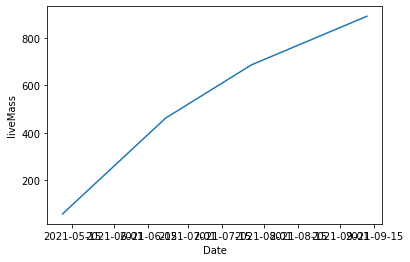

In [3]:
dfargs = dfx[dfx['Year'] == 2021]

sns.lineplot(data = dfargs, x = dfargs.Date, y = dfargs.liveMass)

In [4]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.

def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

#NOTE 10/6/2022 - This has been updated for Landsat Collection 2 https://www.usgs.gov/landsat-missions/landsat-collection-2
#Scaling factors: https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products

In [5]:
##TIDAL FILTERING; from Narron et al. 2022
##Utilizes L8 bands 4 and 6 for NDWI, and bands 3 and 4 (for pheno)
##Does it work for Landsat 5?

def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(flats.rename('flats'))

##Notes: This is setup for Landsat 8 - apply to l5?

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))
##MASKING FLATS
def maskFLATS(image):
    mask1 = image.select('flats').lte(0.1) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

##ADDING NDVI (for min/max variables)
def addL5ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addL8ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

In [6]:
##Pixel extraction functions - addDate for dateless images/collections
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('imagedate').toInt())

##For Landsat images:
def rasterExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 30,
        tileScale = 8 #ADDED 10/6/2022 - make sure it doesn't affect results (see thread below)

    )
    return feature

##FOR 10m DEM:
def demExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 10 
    )
    return feature

##FOR 1m DEM:
def dem1Extraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 1 
    )
    return feature

In [7]:
##Adding DEM
dem = ee.Image('USGS/3DEP/10m') ##This is 1/3 arc second, or 10 m.
dem1 = ee.ImageCollection('USGS/3DEP/1m')

##Set visualization parameters.
dem_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

Map.addLayer(dem, dem_params, '10m DEM')
Map.addLayer(dem1, dem_params, '1m DEM')

In [8]:
##Calculating mean pixel values for time periods within each year

def monthly_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter and set month
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(5, 10, 'month')) \
                              .mean() \
                              .set({'year': year})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)

## Compute monthly averages
# monthly_sowing_Avg = monthly_Avg (ndvi_sowSeason, years, sowingMonths)

##Months and years are lists

years_ls5 = range(1999, 2012)
years_ls7 = range(2012, 2013)
years_ls8 = range(2013, 2021)
years_dm = range(1999, 2021)

months = range(5,11)
months_daymet = range(1,12)

#Note:Landsat datasets migrated to Collection 2

ls5_collect = ee.ImageCollection(
    'LANDSAT/LT05/C02/T1_L2'
).filterBounds(fc_all).map(maskL8sr).map(addFLATSL5).map(maskFLATS).map(addL5ndvi)

ls7_collect = ee.ImageCollection(
    'LANDSAT/LE07/C02/T1_L2'
).filterBounds(fc_all).map(maskL8sr).map(addFLATSL5).map(maskFLATS).map(addL5ndvi)

ls8_collect = ee.ImageCollection(
    'LANDSAT/LC08/C02/T1_L2'
).filterBounds(fc_all).map(maskL8sr).map(addFLATS).map(maskFLATS).map(addL8ndvi)

monthly_ls5 = monthly_Avg(ls5_collect, years = years_ls5)
monthly_ls7 = monthly_Avg(ls7_collect, years = years_ls7)
monthly_ls8 = monthly_Avg(ls8_collect, years = years_ls8)

monthly_ls5.size().getInfo()

##From stackexchange: calculating monthly averages across many years:
#https://gis.stackexchange.com/questions/290892/google-earth-enginesst-by-month-per-year
#https://gis.stackexchange.com/questions/426662/image-collection-monthly-averages-using-geemap-package

13

In [16]:
list_5 = monthly_ls5.toList(monthly_ls5.size())
list_7 = monthly_ls7.toList(monthly_ls7.size())
list_8 = monthly_ls8.toList(monthly_ls8.size())

ls5_1999 = ee.Image(list_5.get(0))
ls5_2000 = ee.Image(list_5.get(1))
ls5_2001 = ee.Image(list_5.get(2))
ls5_2002 = ee.Image(list_5.get(3))
ls5_2003 = ee.Image(list_5.get(4))
ls5_2004 = ee.Image(list_5.get(5))
ls5_2005 = ee.Image(list_5.get(6))
ls5_2006 = ee.Image(list_5.get(7))
ls5_2007 = ee.Image(list_5.get(8))
ls5_2008 = ee.Image(list_5.get(9))
ls5_2009 = ee.Image(list_5.get(10))
ls5_2010 = ee.Image(list_5.get(11))
ls5_2011 = ee.Image(list_5.get(12))

ls7_2012 = ee.Image(list_7.get(0))

ls8_2013 = ee.Image(list_8.get(0))
ls8_2014 = ee.Image(list_8.get(1))
ls8_2015 = ee.Image(list_8.get(2))
ls8_2016 = ee.Image(list_8.get(3))
ls8_2017 = ee.Image(list_8.get(4))
ls8_2018 = ee.Image(list_8.get(5))
ls8_2019 = ee.Image(list_8.get(6))
ls8_2020 = ee.Image(list_8.get(7))

# ls5_2001.getInfo()

{'type': 'Image',
 'bands': [{'id': 'SR_B1',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B2',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B3',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B4',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B5',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B6',
   'data_type': {'ty

In [10]:
##Daymet
def dm_Avg (collection, years):
  avg = []
  for year in years: #Originally had a for month in months subloop, with (month,month,'month') being a filter
      Monthly_avg = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(1, 12, 'month')) \
                              .mean() \
                              .set({'year': year})
      avg.append (Monthly_avg)
  return ee.ImageCollection.fromImages(avg)

daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4').filterBounds(fc_all)

monthly_dm = dm_Avg(daymet, years = years_dm)

dm_list = monthly_dm.toList(monthly_dm.size())

dm_1999 = ee.Image(dm_list.get(0))
dm_2000 = ee.Image(dm_list.get(1))
dm_2001 = ee.Image(dm_list.get(2))
dm_2002 = ee.Image(dm_list.get(3))
dm_2003 = ee.Image(dm_list.get(4))
dm_2004 = ee.Image(dm_list.get(5))
dm_2005 = ee.Image(dm_list.get(6))
dm_2006 = ee.Image(dm_list.get(7))
dm_2007 = ee.Image(dm_list.get(8))
dm_2008 = ee.Image(dm_list.get(9))
dm_2009 = ee.Image(dm_list.get(10))
dm_2010 = ee.Image(dm_list.get(11))
dm_2011 = ee.Image(dm_list.get(12))
dm_2012 = ee.Image(dm_list.get(13))
dm_2013 = ee.Image(dm_list.get(14))
dm_2014 = ee.Image(dm_list.get(15))
dm_2015 = ee.Image(dm_list.get(16))
dm_2016 = ee.Image(dm_list.get(17))
dm_2017 = ee.Image(dm_list.get(18))
dm_2018 = ee.Image(dm_list.get(19))
dm_2019 = ee.Image(dm_list.get(20))
dm_2020 = ee.Image(dm_list.get(21))

# dm_2020.getInfo()

In [17]:
##Monthly/yearly extraction - NOTE: Takes a while to run

dem_vals = geemap.ee_to_pandas(demExtraction(dem)) ##10m dataset
# dem_vals = geemap.ee_to_pandas(dem1.map(dem1Extraction).flatten()) ##ONE METER DATASET

# daymet_vals = geemap.ee_to_pandas(monthly_dm.map(rasterExtraction).flatten())
xdm_1999 = geemap.ee_to_pandas(rasterExtraction(dm_1999))
xdm_2000 = geemap.ee_to_pandas(rasterExtraction(dm_2000))
xdm_2001 = geemap.ee_to_pandas(rasterExtraction(dm_2001))
xdm_2002 = geemap.ee_to_pandas(rasterExtraction(dm_2002))
xdm_2003 = geemap.ee_to_pandas(rasterExtraction(dm_2003))
xdm_2004 = geemap.ee_to_pandas(rasterExtraction(dm_2004))
xdm_2005 = geemap.ee_to_pandas(rasterExtraction(dm_2005))
xdm_2006 = geemap.ee_to_pandas(rasterExtraction(dm_2006))
xdm_2007 = geemap.ee_to_pandas(rasterExtraction(dm_2007))
xdm_2008 = geemap.ee_to_pandas(rasterExtraction(dm_2008))
xdm_2009 = geemap.ee_to_pandas(rasterExtraction(dm_2009))
xdm_2010 = geemap.ee_to_pandas(rasterExtraction(dm_2010))
xdm_2011 = geemap.ee_to_pandas(rasterExtraction(dm_2011))
xdm_2012 = geemap.ee_to_pandas(rasterExtraction(dm_2012))
xdm_2013 = geemap.ee_to_pandas(rasterExtraction(dm_2013))
xdm_2014 = geemap.ee_to_pandas(rasterExtraction(dm_2014))
xdm_2015 = geemap.ee_to_pandas(rasterExtraction(dm_2015))
xdm_2016 = geemap.ee_to_pandas(rasterExtraction(dm_2016))
xdm_2017 = geemap.ee_to_pandas(rasterExtraction(dm_2017))
xdm_2018 = geemap.ee_to_pandas(rasterExtraction(dm_2018))
xdm_2019 = geemap.ee_to_pandas(rasterExtraction(dm_2019))
xdm_2020 = geemap.ee_to_pandas(rasterExtraction(dm_2020))

##Raster vals
# geemap.ee_to_pandas(monthly_ls5.map(rasterExtraction).flatten())
x_1999 = geemap.ee_to_pandas(rasterExtraction(ls5_1999))
x_2000 = geemap.ee_to_pandas(rasterExtraction(ls5_2000))
# x_2001 = geemap.ee_to_pandas(rasterExtraction(ls5_2001)) ##No augoct?
x_2002 = geemap.ee_to_pandas(rasterExtraction(ls5_2002))
# x_2003 = geemap.ee_to_pandas(rasterExtraction(ls5_2003)) ##No sep
x_2004 = geemap.ee_to_pandas(rasterExtraction(ls5_2004))
x_2005 = geemap.ee_to_pandas(rasterExtraction(ls5_2005))
x_2006 = geemap.ee_to_pandas(rasterExtraction(ls5_2006))
x_2007 = geemap.ee_to_pandas(rasterExtraction(ls5_2007))
x_2008 = geemap.ee_to_pandas(rasterExtraction(ls5_2008))
x_2009 = geemap.ee_to_pandas(rasterExtraction(ls5_2009))
x_2010 = geemap.ee_to_pandas(rasterExtraction(ls5_2010))
x_2011 = geemap.ee_to_pandas(rasterExtraction(ls5_2011))
x_2012 = geemap.ee_to_pandas(rasterExtraction(ls7_2012))
x_2013 = geemap.ee_to_pandas(rasterExtraction(ls8_2013))
x_2014 = geemap.ee_to_pandas(rasterExtraction(ls8_2014))
x_2015 = geemap.ee_to_pandas(rasterExtraction(ls8_2015))
x_2016 = geemap.ee_to_pandas(rasterExtraction(ls8_2016))
x_2017 = geemap.ee_to_pandas(rasterExtraction(ls8_2017))
# x_2018 = geemap.ee_to_pandas(rasterExtraction(ls8_2018)) ##No sep
x_2019 = geemap.ee_to_pandas(rasterExtraction(ls8_2019))
# x_2020 = geemap.ee_to_pandas(rasterExtraction(ls8_2020)) ##No sep

display(x_2000)

# ls8_vals = geemap.ee_to_pandas(monthly_ls8.map(rasterExtraction).flatten())

Exception: Element.propertyNames: Parameter 'element' is required.

In [ ]:
##Subsetting dataframes for each year
#Landsat
x_1999 = x_1999[x_1999['Year'] == 1999]
x_2000 = x_2000[x_2000['Year'] == 2000]
x_2001 = x_2001[x_2001['Year'] == 2001]
x_2002 = x_2002[x_2002['Year'] == 2002]
x_2003 = x_2003[x_2003['Year'] == 2003]
x_2004 = x_2004[x_2004['Year'] == 2004]
x_2005 = x_2005[x_2005['Year'] == 2005]
x_2006 = x_2006[x_2006['Year'] == 2006]
x_2007 = x_2007[x_2007['Year'] == 2007]
x_2008 = x_2008[x_2008['Year'] == 2008]
x_2009 = x_2009[x_2009['Year'] == 2009]
x_2010 = x_2010[x_2010['Year'] == 2010]
x_2011 = x_2011[x_2011['Year'] == 2011]
x_2012 = x_2012[x_2012['Year'] == 2012]
x_2013 = x_2013[x_2013['Year'] == 2013]
x_2014 = x_2014[x_2014['Year'] == 2014]
x_2015 = x_2015[x_2015['Year'] == 2015]
x_2016 = x_2016[x_2016['Year'] == 2016]
x_2017 = x_2017[x_2017['Year'] == 2017]
x_2018 = x_2018[x_2018['Year'] == 2018]
x_2019 = x_2019[x_2019['Year'] == 2019]
x_2020 = x_2020[x_2020['Year'] == 2020]

#Daymet
xdm_1999 = xdm_1999[xdm_1999['Year'] == 1999]
xdm_2000 = xdm_2000[xdm_2000['Year'] == 2000]
xdm_2001 = xdm_2001[xdm_2001['Year'] == 2001]
xdm_2002 = xdm_2002[xdm_2002['Year'] == 2002]
xdm_2003 = xdm_2003[xdm_2003['Year'] == 2003]
xdm_2004 = xdm_2004[xdm_2004['Year'] == 2004]
xdm_2005 = xdm_2005[xdm_2005['Year'] == 2005]
xdm_2006 = xdm_2006[xdm_2006['Year'] == 2006]
xdm_2007 = xdm_2007[xdm_2007['Year'] == 2007]
xdm_2008 = xdm_2008[xdm_2008['Year'] == 2008]
xdm_2009 = xdm_2009[xdm_2009['Year'] == 2009]
xdm_2010 = xdm_2010[xdm_2010['Year'] == 2010]
xdm_2011 = xdm_2011[xdm_2011['Year'] == 2011]
xdm_2012 = xdm_2012[xdm_2012['Year'] == 2012]
xdm_2013 = xdm_2013[xdm_2013['Year'] == 2013]
xdm_2014 = xdm_2014[xdm_2014['Year'] == 2014]
xdm_2015 = xdm_2015[xdm_2015['Year'] == 2015]
xdm_2016 = xdm_2016[xdm_2016['Year'] == 2016]
xdm_2017 = xdm_2017[xdm_2017['Year'] == 2017]
xdm_2018 = xdm_2018[xdm_2018['Year'] == 2018]
xdm_2019 = xdm_2019[xdm_2019['Year'] == 2019]
xdm_2020 = xdm_2020[xdm_2020['Year'] == 2020]

landsat_list = [
    x_1999,x_2000,x_2001,x_2002,x_2003,x_2004,x_2005,x_2006,x_2007,x_2008,x_2009,x_2010,x_2011,x_2012,x_2013,x_2014,x_2015,
    x_2016,x_2017,
    x_2018,x_2019,x_2020
]

landsat_extract = pd.concat(landsat_list)

daymet_list = [
    xdm_1999,xdm_2000,xdm_2001,xdm_2002,xdm_2003,xdm_2004,xdm_2005,xdm_2006,xdm_2007,xdm_2008,xdm_2009,xdm_2010,xdm_2011,
    xdm_2012,xdm_2013,
    xdm_2014,xdm_2015,xdm_2016,xdm_2017,xdm_2018,xdm_2019,xdm_2020
]

daymet_extract = pd.concat(daymet_list)

landsat_extract.drop('Date', axis=1, inplace=True)
daymet_extract.drop('Date', axis=1, inplace=True)
# dem_vals.drop('Date', axis=1, inplace=True)

dfx = pd.merge(landsat_extract, dem_vals, how = 'left')

# dfx.drop('Date', axis=1, inplace=True)

df = pd.merge(dfx, daymet_extract, how = 'right')

display(df)

In [12]:
##Bands and indices
df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df.loc[df['Year'] == 2012, 'Sensor'] = 'Landsat 7'

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 8', (df['SR_B5']-df['SR_B4'])/(df['SR_B5']+df['SR_B4']), \
                      (df['SR_B4']-df['SR_B3'])/(df['SR_B4']+df['SR_B3'])) 
##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 8', df['SR_B2'], df['SR_B1'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 8', df['SR_B3'], df['SR_B2'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 8', df['SR_B4'], df['SR_B3'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 8', df['SR_B5'], df['SR_B4'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 8', df['SR_B6'], df['SR_B5'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 8', df['SR_B7'], df['SR_B7'])

##Variables from Byrd et al. 2018 (make sure calculations are accurate):
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

display(df)

##EXPORT
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'ma_mayoct.csv')
# df.to_csv(out_csv, index = False)

KeyError: 'Year'

In [ ]:
##Be careful